<a href="https://colab.research.google.com/github/mr-ayush-agrawal/DL_Notebooks/blob/main/Wine%20Review/FCC_Tutorial_Wine_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is for the Lecture of the FreeCodeCamp -  wine review [This Video](https://www.youtube.com/watch?v=VtRLrQ3Ev-U)

The dataset is available in the discription of the video

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
cols = ['country', 'description', 'points', 'price', 'variety', 'winery']
df = pd.read_csv('./wine_reviews.csv', usecols = cols)
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df.isna().sum()

country          63
description       0
points            0
price          8996
variety           1
winery            0
dtype: int64

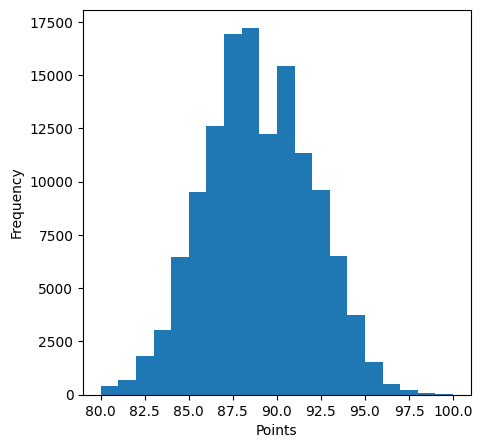

In [ ]:
plot_fig = True
if plot_fig :
  plt.figure(figsize = (5,5))
  plt.hist(df.points, bins = 20)
  plt.xlabel('Points')
  plt.ylabel('Frequency')

In [ ]:
df['label'] = (df.points >= 90).astype(int)

df2 = df[['description', 'label']]
df2.sample(10)

,description,label
5448,A touch of dried apple skin and cinnamon stick...,0
58136,"Like many Roero wines this vintage, the winnin...",0
99426,This is almost as impressive as Gerin's La Cha...,0
70886,This expression of Sangiovese offers thick ext...,1
86764,"Ripe and juicy, this is a wine with structure ...",1
59528,"Acidity marks this bone dry, tightly wound and...",1
41764,"This block selection is supple, almost silky, ...",1
102137,Berry and cinnamon aromas are lightly woody an...,1
26032,"If this Merlot had greater flavor intensity, i...",0
41472,"Buttered toast, yeast and a hint of nut wrap a...",0


In [ ]:
len(df2[df2.label == 1]), len(df2[df2.label == 0])

(49045, 80926)

In [ ]:
# Splitting using the numpy split funciton
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])
len(train), len(val), len(test)

(103976, 12997, 12998)

In [ ]:
# This converts a dataframe to `tf.data.Dataset` object -> copied from tensorflow module
def df_to_dataset(dataframe, shuffle= True, batch_size = 1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df.description  # as our data only contains the description and the label column
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle :
    ds = ds.shuffle(buffer_size = len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

## Embedding + Modeling

In [ ]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'

hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 4.85971451e-01, -3.20071280e-01,  3.08040027e-02, ...,
         6.14857525e-02, -1.06676154e-01, -6.15928657e-02],
       [ 3.72114241e-01, -1.85034588e-01,  4.30617183e-02, ...,
         2.84280986e-01, -1.78986967e-01, -2.08974201e-02],
       [ 4.50332999e-01, -3.22733879e-01,  8.14256165e-03, ...,
        -7.05574304e-02, -1.57926217e-01, -9.61552002e-03],
       ...,
       [ 3.51874083e-01,  2.77191103e-02, -7.98245594e-02, ...,
        -2.39906571e-04, -1.42555162e-01, -1.61523119e-01],
       [ 6.41487420e-01, -6.27303794e-02,  1.31580874e-01, ...,
        -2.75812864e-01,  5.70682287e-02,  4.06708047e-02],
       [ 1.27983823e-01, -4.09074873e-01, -8.49592835e-02, ...,
         5.15371375e-02,  1.44387320e-01, -2.27868289e-01]], dtype=float32)>

Here above we use embedding to convert the words (strings) to a 50 diamension vector.

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)    # converts text to vector
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
# Evaluating the untrained model on train_data
model.evaluate(train_data)

102/102 [==============================] - 11s 108ms/step - loss: 0.0256 - accuracy: 0.9934


[0.02562231384217739, 0.9934023022651672]

In [ ]:
model.evaluate(val_data)

13/13 [==============================] - 2s 138ms/step - loss: 1.1618 - accuracy: 0.8206


[1.1618471145629883, 0.8205739855766296]

In [ ]:
history = model.fit(train_data, epochs = 7, validation_data = val_data)

Epoch 1/7
102/102 [==============================] - 79s 765ms/step - loss: 0.0464 - accuracy: 0.9862 - val_loss: 1.3012 - val_accuracy: 0.8208
Epoch 2/7
102/102 [==============================] - 86s 845ms/step - loss: 0.0423 - accuracy: 0.9877 - val_loss: 1.4283 - val_accuracy: 0.8223
Epoch 3/7
102/102 [==============================] - 75s 732ms/step - loss: 0.0366 - accuracy: 0.9900 - val_loss: 1.5410 - val_accuracy: 0.8220
Epoch 4/7
102/102 [==============================] - 75s 732ms/step - loss: 0.0346 - accuracy: 0.9907 - val_loss: 1.7236 - val_accuracy: 0.8220
Epoch 5/7
102/102 [==============================] - 74s 730ms/step - loss: 0.0331 - accuracy: 0.9915 - val_loss: 1.8091 - val_accuracy: 0.8229
Epoch 6/7
102/102 [==============================] - 75s 735ms/step - loss: 0.0312 - accuracy: 0.9917 - val_loss: 1.9471 - val_accuracy: 0.8213
Epoch 7/7
102/102 [==============================] - 75s 732ms/step - loss: 0.0305 - accuracy: 0.9921 - val_loss: 2.0470 - val_accuracy:

Model got overfit for `history = model.fit(train_data, epochs = 15, validation_data = val_data)`

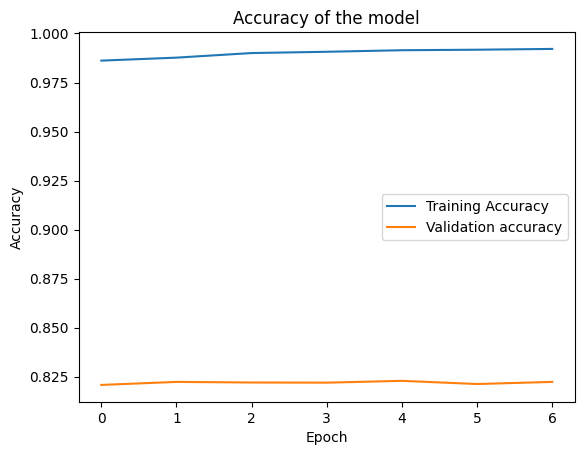

In [ ]:
plt.plot(history.history['accuracy'], label = "Training Accuracy")
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

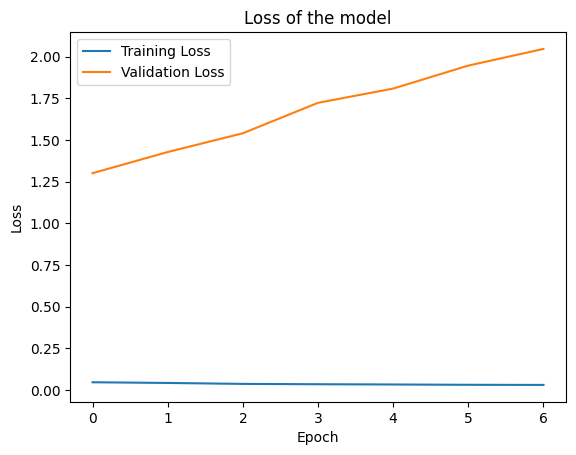

In [ ]:
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss of the model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Overfitting can be removed by multiple ways, One of the way is adding dropout.

DropOut -> These layers remove the datarows which are not really working for the model while training.

In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 2s 129ms/step - loss: 2.0953 - accuracy: 0.8206


[2.0952982902526855, 0.8205877542495728]

## LSTM

We are not going to use the hub for this purpose as we want more control over the model



In [82]:
# first we are going to create some encoder for the text
encoder = tf.keras.layers.TextVectorization(max_tokens=2500)
encoder.adapt(train_data.map(lambda text, label : text))

In [83]:
vocab = np.array(encoder.get_vocabulary())
vocab[:25]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that', 'finish', 'acidity', 'from', 'tannins', 'but'],
      dtype='<U17')

In [85]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [86]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [87]:
model.evaluate(train_data)

102/102 [==============================] - 15s 130ms/step - loss: 0.6936 - accuracy: 0.4320


[0.6936301589012146, 0.4319746792316437]

In [88]:
model.evaluate(val_data)

13/13 [==============================] - 2s 119ms/step - loss: 0.6936 - accuracy: 0.4296


[0.6936393976211548, 0.429637610912323]

In [91]:
history = model.fit(train_data, epochs = 7, validation_data = val_data, batch_size = 512)

Epoch 1/7
102/102 [==============================] - 25s 244ms/step - loss: 0.2429 - accuracy: 0.8900 - val_loss: 0.3979 - val_accuracy: 0.8394
Epoch 2/7
102/102 [==============================] - 25s 243ms/step - loss: 0.2290 - accuracy: 0.8957 - val_loss: 0.4214 - val_accuracy: 0.8418
Epoch 3/7
102/102 [==============================] - 25s 244ms/step - loss: 0.2263 - accuracy: 0.8967 - val_loss: 0.4286 - val_accuracy: 0.8413
Epoch 4/7
102/102 [==============================] - 25s 248ms/step - loss: 0.2111 - accuracy: 0.9025 - val_loss: 0.4479 - val_accuracy: 0.8369
Epoch 5/7
102/102 [==============================] - 25s 243ms/step - loss: 0.2051 - accuracy: 0.9060 - val_loss: 0.4741 - val_accuracy: 0.8397
Epoch 6/7
102/102 [==============================] - 27s 260ms/step - loss: 0.1942 - accuracy: 0.9110 - val_loss: 0.4658 - val_accuracy: 0.8406
Epoch 7/7
102/102 [==============================] - 25s 246ms/step - loss: 0.1847 - accuracy: 0.9155 - val_loss: 0.4917 - val_accuracy:

We have pretty good accuracy and doesn't seem to overfit

In [92]:
model.evaluate(test_data)

13/13 [==============================] - 2s 159ms/step - loss: 0.5309 - accuracy: 0.8324


[0.5308740139007568, 0.8323588371276855]